In [1]:
%load_ext autoreload
%autoreload 2

import pandas as pd
import numpy as np
import random
import os

np.random.seed(1)
random.seed(1)
DATA_DIR = "/media/DATA/zalo-hit-song-prediction/csv/"
TRAININFO = os.path.join(DATA_DIR, "train_info.tsv")
TRAINRANK =  os.path.join(DATA_DIR, "train_rank.csv")
TESTINFO = os.path.join(DATA_DIR, "test_info.tsv")
SUBMISSION = os.path.join(DATA_DIR, "submission.csv")

# Prepare data
df_i = pd.read_csv(TRAININFO, delimiter='\t',encoding='utf-8')
df_r = pd.read_csv(TRAINRANK)
df_i_train = df_i.merge(df_r, left_on='ID', right_on='ID')
df_i_train["dataset"] = "train"

df_i_test = pd.read_csv(TESTINFO, delimiter='\t',encoding='utf-8')
df_i_test["label"] = np.nan
df_i_test["dataset"] = "test"

df = pd.concat([df_i_train, df_i_test])
df_track_info = pd.read_csv(os.path.join(DATA_DIR, "all_track_info.csv"))
df = df.merge(df_track_info, left_on='ID', right_on='ID')
df_audio_features = pd.read_csv(os.path.join(DATA_DIR, "all_track_audio_features.csv"))
df =df.merge(df_audio_features,left_on="ID",right_on="ID", how="left")
df_album_hash = pd.read_csv(os.path.join(DATA_DIR, "album_hash.csv")) 
df =df.merge(df_album_hash,left_on="ID",right_on="ID", how="left")

# Sort by ID
df = df.sort_values(by=['ID'])
df= df.reset_index()

df.head(2)



,index,ID,title,artist_name,artist_id,composers_name,composers_id,release_time,label,dataset,...,tonal.chords_key,tonal.chords_scale,tonal.key_edma.key,tonal.key_edma.scale,tonal.key_krumhansl.key,tonal.key_krumhansl.scale,tonal.key_temperley.key,tonal.key_temperley.scale,Unnamed: 0,album_hash
0,0,1073748245,Đêm Chôn Dầu Vượt Biển,Như Quỳnh,551,Châu Đình An,5765,2017-10-01 22:07:00,7.0,train,...,D,major,G,major,G,major,G,major,0,3c5c7e72f9112800
1,1,1073751978,Mùa Thu Trong Mưa,Minh Tuyết,455,Trường Sa,100105,2017-10-01 20:58:00,3.0,train,...,C,minor,C,minor,C,minor,C,minor,1,f39df9c10843e3fc


In [2]:
from format_features import format_features
df = format_features(df)

There is 0.24038838760298156 ratio is nan album
There is 0.0017653981953707335 ratio is nan genre
There is 0.24038838760298156 ratio is nan album_artist
There is 0.0007846214201647705 ratio is nan track
There is 0.6722244017261672 ratio is nan lyric
2711 raw titles are identical between songs: 7485 unique titles
After cleaning brackets etc. only 6202 unique titles remain, i.e. 1283 are highly similar titles 
In making albumHashandName, we filled in: 146 values Of the total albumHashAndName 171 nan
In making albumHashAndNameAndReleaseday, we filled in the: 171 values remaining using the release second hash
There is a statistically signficiant relationship between English-like title and rank. So adding feature: isEnglishLikeTitle


In [3]:
all_features_in_order = {## album is Redundant feature use: albumHashAndNameAndReleaseday", # album name from mp3 metadata textual
                          "albumHashAndNameAndReleaseday":"category",
                          "len_album_name":"int64",
                          "isRemixAlbum":"category",
                          "isOSTAlbum":"category",
                          "isSingleAlbum":"category",
                          "isBeatAlbum":"category",
                          "isTopHitAlbum":"category",
                          "isCoverAlbum":"category",
                          "isEPAlbum":"category",
                          "isLienKhucAlbum":"category",
                          "album_name_is_title_name":"category",
                          "artist_name":"category",
                          "composers_name":"category",
                          "copyright":"category" ,
                          "artist_id_min":"category",
                          "artist_id_max":"category", 
                          "composers_id_min":"category", 
                          "composers_id_max":"category",
                          "genre":"category", 
                          "album_artist":"category", # album artist name
                          "album_artist_contain_artistname":"category",
                          "track":"float64", # float between 0 and 1 representing track_num/total_tracks
                          "istrack11":"category", # 1 if first track
                          # "lyric":"string" # Not a trainable feature
                          "islyric":"category",
                          "num_line_lyric":"int64",
                          "no_artist":"int64",
                          "no_composer":"int64",
                          #"datetime":"datetime64", # Not a trainable feature
                          "day":"category",
                          "month":"category",
                          "year":"category",
                          "hour":"category",
                          "dayofyear":"category",
                          "weekday":"category",
                          "isHoliday":"category",
                          "len_of_songname":"int64",
                          "isRemix":"category",
                          "isOST":"category",
                          "isBeat":"category",
                          "isVersion":"category",
                          "isCover":"category",
                          "isLienKhuc":"category",
                          "day_release":"int64", # the specific day of the day across all days (> 365)  
                          "datetimeIs_month_end":"category",
                          "datetimeIs_month_start":"category",
                          "datetimeIs_quarter_end":"category",
                          "datetimeIs_quarter_start":"category",
                          "datetimeIs_year_end":"category",
                          "datetimeIs_year_start":"category",
                          "datetimeDayofweek":"category",
                          "tonal.chords_key":"category",
                          "tonal.chords_scale":"category",
                          'datetimeweekday_cos':"float64",
                          'datetimeweekday_sin':"float64", 
                          'datetimeday_month_cos':"float64",
                          'datetimeday_month_sin':"float64", 
                          'datetimemonth_year_cos':"float64",
                          'datetimemonth_year_sin':"float64", 
                          'datetimeday_year_cos':"float64",
                          'datetimeday_year_sin':"float64",
                          "length":"float64", # length of the song (s?)
                          # (title feature likely rendered redundant - use title_truncated )"title":"category",
                          'title_truncated':"category",
                          ###########################
                          # Warning: the below features those that require "global" knowledge beyond that example
                          ###########################
                          "numsongInAlbum":"category",
                          "isSingleAlbum_onesong":"category",
                           #"num_song_released_that_week":'int64',
                          "num_song_release_in_final_month":"int64",  
                          "freq_artist":"int64",  # number of times the unique artist string is present in dataset
                          "freq_artist_min":"int64", # number of times the first listed artist is present in dataset
                          "num_album_per_min_artist":"int64",
                          "num_album_per_min_composer":"int64",
                          "freq_composer_min":"int64",   
                          "isEnglishLikeTitle":"category" # has some words with no special charachters - in practice selects short and weird titles
                          }

def add_raw_audio_features(df, all_features_in_order):
    not_included_columns = set(df.columns) - set([i for i in all_features_in_order.keys()]) - set(["tonal.chords_key", "tonal.chords_scale"])
    audio_feature_names = sorted([i for i in not_included_columns if i.split(".")[0] == 'tonal'
            or  i.split(".")[0] == 'rhythm'
            or  i.split(".")[0]=='lowlevel'])
    pd.set_option('display.max_columns', 500)
    audio_feature_names_dict = {name:"float64" for name in audio_feature_names}
    audio_feature_names_dict["tonal.chords_key"] = "category"
    audio_feature_names_dict["tonal.chords_scale"] = "category"
    audio_feature_names_dict["tonal.key_edma.key"] = "category"
    audio_feature_names_dict["tonal.key_edma.scale"] = "category"
    audio_feature_names_dict["tonal.key_krumhansl.key"] = "category"
    audio_feature_names_dict["tonal.key_krumhansl.scale"] = "category"
    audio_feature_names_dict["tonal.key_temperley.key"] = "category"
    audio_feature_names_dict["tonal.key_temperley.scale"] = "category"
    all_features_in_order.update(audio_feature_names_dict)
    return all_features_in_order

all_features_in_order = add_raw_audio_features(df, all_features_in_order)
all_features_in_order_list = list(all_features_in_order.keys())
for feat_name, feat_type in all_features_in_order.items():
    try:
        df[feat_name] = df[feat_name].astype(feat_type)
    except ValueError:
        print(feat_name, feat_type)
        raise


In [5]:
from measure_dataframe_mutual_inf import get_numerical_mutual_info
mutual_info_numerical = get_numerical_mutual_info(df, all_features_in_order_list)
print(mutual_info_numerical)

cross validation  0


/media/DATA/anaconda3/envs/thriai/lib/python3.6/site-packages/pandas/core/generic.py:5434: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._update_inplace(new_data)


cross validation  1


/media/DATA/anaconda3/envs/thriai/lib/python3.6/site-packages/pandas/core/generic.py:5434: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._update_inplace(new_data)


cross validation  2


/media/DATA/anaconda3/envs/thriai/lib/python3.6/site-packages/pandas/core/generic.py:5434: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._update_inplace(new_data)


lowlevel.dissonance.stdev                        0.000000
lowlevel.erbbands_crest.mean                     0.000000
lowlevel.erbbands_spread.stdev                   0.000196
tonal.chords_strength.stdev                      0.000397
tonal.key_temperley.strength                     0.000535
lowlevel.erbbands_skewness.stdev                 0.000540
lowlevel.loudness_ebu128.loudness_range          0.000553
lowlevel.average_loudness                        0.000587
lowlevel.loudness_ebu128.short_term.stdev        0.000891
lowlevel.spectral_energyband_middle_low.stdev    0.000919
tonal.tuning_equal_tempered_deviation            0.001000
lowlevel.spectral_energyband_low.stdev           0.001060
lowlevel.erbbands_kurtosis.stdev                 0.001089
lowlevel.spectral_rolloff.stdev                  0.001308
lowlevel.loudness_ebu128.momentary.stdev         0.001355
lowlevel.zerocrossingrate.stdev                  0.001374
lowlevel.hfc.stdev                               0.001540
lowlevel.spect

In [15]:
import lightgbm as lgb
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from format_features import baysianEncodeFeature
best_chosen_features = ["album", "istrack11", "no_artist", "freq_artist", "freq_composer","year", "month","hour", "day", "len_of_songname", 
                   "isRemix", "isOST", "isBeat", "isVersion", "isCover",  "num_song_release_in_final_month",
                  "length", "genre", "track","album_artist", "islyric", "album_artist_contain_artistname",
                  "len_album_name", "isRemixAlbum", "isOSTAlbum", "isSingleAlbum", "album_name_is_title_name",
                  "isBeatAlbum", "isCoverAlbum", "artist_name","composers_name","copyright" ,
                  "artist_id_min", "composers_id_min",  "artist_id_max", "composers_id_max", 
                   "freq_artist_min", "freq_composer_min","dayofyear","weekday","isHoliday",
                  "num_album_per_min_artist", "num_album_per_min_composer", 
                   "numsongInAlbum","isSingleAlbum_onesong",
                   # added following and removed no_composer which carries no mutual info. changes num leaves to 20, changed min_data_in_leaf to 100 to reduce overfitting
                   "rhythm.bpm_histogram_second_peak_weight","day_release","lowlevel.barkbands_kurtosis.stdev",
                  "rhythm.beats_count", "lowlevel.pitch_salience.stdev", "lowlevel.erbbands_flatness_db.stdev"]


df = df.copy()

categorical_col_names = df[all_features_in_order_list].select_dtypes(include=['category']).columns
for colname in categorical_col_names:
    df[colname] = df[colname].cat.codes
    

df = baysianEncodeFeature(df, 'albumHashAndNameAndReleaseday', prior_weight=4, fillmissing=-1, suffix='_enc')
df = baysianEncodeFeature(df, 'artist_id_min', prior_weight=4, fillmissing=-1, suffix='_enc')
df = baysianEncodeFeature(df, 'title_truncated', prior_weight=4, fillmissing=-1, suffix='_enc')


bens_chosen_features = ["albumHashAndNameAndReleaseday_enc",
                        "artist_id_min_enc",
                        "title_truncated_enc",
                        "day",
                        "dayofyear", 
                        "datetimeday_year_sin","datetimeday_year_cos","datetimemonth_year_sin", "datetimemonth_year_cos", 
                        "datetimeday_month_sin", "datetimeday_month_cos", "datetimeweekday_sin", "datetimeweekday_cos"]

chosen_features = bens_chosen_features

df_train = df[df.dataset=="train"]
df_test = df[df.dataset=="test"]

param = {
    'bagging_freq': 20,          
    'bagging_fraction': 0.95,   'boost_from_average':'false',   
    'boost': 'gbdt',             'feature_fraction': 0.1,     'learning_rate': 0.001,
    'max_depth': -1,             'metric':'root_mean_squared_error', 'min_data_in_leaf': 100, # cjha   
       'num_leaves': 20,            
    'num_threads': 4,              'tree_learner': 'serial',   'objective': 'regression',
    'reg_alpha': 0.1002650970728192, 'reg_lambda': 0.1003427518866501,'verbosity': 1,
    "seed": 99999
}

folds = StratifiedKFold(n_splits=10, shuffle=True, random_state=99999)
oof = np.zeros(len(df_train))
predictions = np.zeros(len(df_test))
labels= df_train.label
# fig, axes = plt.subplots(5, 1, figsize=(10, 10*5))
# axes = axes.flat
for fold_, (trn_idx, val_idx) in enumerate(folds.split(df_train.values, df_train.label.values)):
    print("Fold {}".format(fold_))
    train_df_fold = df_train.iloc[trn_idx][chosen_features]
    val_df_fold = df_train.iloc[val_idx][chosen_features]
    
    #train_means = train_df_fold.select_dtypes(include=['float64']).mean()
    #train_df_fold[train_df_fold.select_dtypes(include=['float64']).columns] = train_df_fold.select_dtypes(include=['float64']).fillna(train_means)  # data leakage unless done inside folds
    #val_df_fold[val_df_fold.select_dtypes(include=['float64']).columns] = val_df_fold.select_dtypes(include=['float64']).fillna(train_means)  # data leakage unless done inside folds

    trn_data = lgb.Dataset(train_df_fold, label=labels.iloc[trn_idx])
    val_data = lgb.Dataset(val_df_fold, label=labels.iloc[val_idx])
    print()
    clf = lgb.train(param, trn_data, 1000000, valid_sets = [trn_data, val_data], verbose_eval=5000, early_stopping_rounds = 20000)
    oof[val_idx] = clf.predict(df_train.iloc[val_idx][chosen_features], num_iteration=clf.best_iteration)
    predictions += clf.predict(df_test[chosen_features], num_iteration=clf.best_iteration) / folds.n_splits
# training's rmse: 0.428706	valid_1's rmse: 1.57874


/media/DATA/anaconda3/envs/thriai/lib/python3.6/site-packages/xam/feature_extraction/encoding/bayesian_target.py:88: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  X[name + self.suffix] = x.map(posteriors).fillna(self.prior_).astype(float)
/media/DATA/zalo-hit-song-prediction/Members/Ben/format_features.py:335: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  _resulting_df[featurename + suffix] = _resulting_df[featurename + suffix].astype('float64')
/media/DATA/anaconda3/envs/thriai/lib/python3.6/site-packages/pandas/core/generic.py:5434: Setti

Fold 0

Training until validation scores don't improve for 20000 rounds
[5000]	training's rmse: 1.41817	valid_1's rmse: 1.39023
[10000]	training's rmse: 1.33504	valid_1's rmse: 1.30599
[15000]	training's rmse: 1.31428	valid_1's rmse: 1.29324
[20000]	training's rmse: 1.30176	valid_1's rmse: 1.28756
[25000]	training's rmse: 1.29269	valid_1's rmse: 1.28444
[30000]	training's rmse: 1.28541	valid_1's rmse: 1.28252
[35000]	training's rmse: 1.27931	valid_1's rmse: 1.28118
[40000]	training's rmse: 1.27412	valid_1's rmse: 1.28067
[45000]	training's rmse: 1.26966	valid_1's rmse: 1.28014
[50000]	training's rmse: 1.26562	valid_1's rmse: 1.28007
[55000]	training's rmse: 1.26197	valid_1's rmse: 1.27992
[60000]	training's rmse: 1.25868	valid_1's rmse: 1.28
[65000]	training's rmse: 1.25559	valid_1's rmse: 1.2803
[70000]	training's rmse: 1.25285	valid_1's rmse: 1.28061
Early stopping, best iteration is:
[53282]	training's rmse: 1.26315	valid_1's rmse: 1.27983
Fold 1

Training until validation scores do

[135000]	training's rmse: 1.22109	valid_1's rmse: 1.36482
[140000]	training's rmse: 1.2198	valid_1's rmse: 1.36463
[145000]	training's rmse: 1.21857	valid_1's rmse: 1.3647
[150000]	training's rmse: 1.21736	valid_1's rmse: 1.36451
[155000]	training's rmse: 1.21619	valid_1's rmse: 1.36452
[160000]	training's rmse: 1.21504	valid_1's rmse: 1.36454
[165000]	training's rmse: 1.21398	valid_1's rmse: 1.36444
[170000]	training's rmse: 1.21291	valid_1's rmse: 1.36431
[175000]	training's rmse: 1.21187	valid_1's rmse: 1.36436
[180000]	training's rmse: 1.21084	valid_1's rmse: 1.36438
[185000]	training's rmse: 1.20986	valid_1's rmse: 1.36434
[190000]	training's rmse: 1.20889	valid_1's rmse: 1.36455
Early stopping, best iteration is:
[171120]	training's rmse: 1.21271	valid_1's rmse: 1.36416
Fold 8

Training until validation scores don't improve for 20000 rounds
[5000]	training's rmse: 1.41827	valid_1's rmse: 1.38055
[10000]	training's rmse: 1.3343	valid_1's rmse: 1.30678
[15000]	training's rmse: 1.31

In [20]:
from math import sqrt

print("RMSE: {:<8.5f}".format(sqrt(mean_squared_error(df_train.label, oof))))
sub = pd.DataFrame({"ID": df_test.ID.values})
sub["label"] = predictions
sub.to_csv("submission_lightgbm.csv", index=False, header=False)

RMSE: 1.28400 


<Figure size 2160x2160 with 0 Axes>

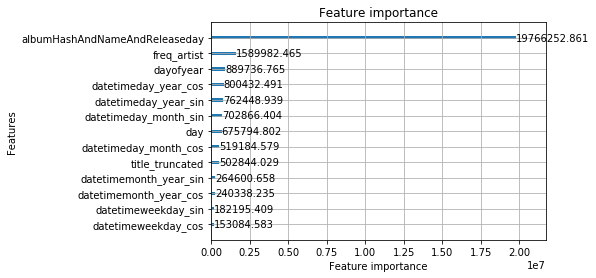

In [40]:
import matplotlib.pyplot as plt
fig = plt.figure(figsize=(30,30))
lgb.plot_importance(clf, max_num_features=20,importance_type='gain')
fig.savefig('exp1.png')

In [36]:
from sklearn.externals import joblib
# save model
joblib.dump(clf, 'exp1.pkl')
# load model
gbm_pickle = joblib.load('exp1.pkl')

/media/DATA/anaconda3/envs/thriai/lib/python3.6/site-packages/sklearn/externals/joblib/__init__.py:15: DeprecationWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=DeprecationWarning)
